In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import ipynb

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Importing formulas from thesis 3 file
#from ipynb.fs.full.Thesis_3_Modeling import dataframe_generation_scores

In [3]:
df_sample=pd.read_csv('df_sample.csv',sep=',')
    #formating the date column
df_sample.Date=pd.to_datetime(df_sample.Date, format="%Y-%m-%d")

In [4]:
df_sample.Cus_ID.unique()

array([ 8568,  8611,  8629,  8741,  8775,  8843,  8963,  8985,  9175,
        9370,  9480,  9658,  9701,  9714,  9751,  9797,  9827,  9857,
        9881, 10174, 10204, 10224, 10289, 10542, 10563, 10683, 10741,
       11041, 11065, 11166, 11578, 11667, 11674, 11825, 12028, 12111,
       12143, 12146, 12303, 12331, 12468, 12653, 12822, 12909, 12987,
       12993, 13026, 13095, 13114, 13180, 13310, 13929, 14189, 14484,
       14500, 14507, 14508, 14567, 14599, 14610, 14844, 15070, 15078,
       15176, 15249, 15269, 15447, 15743, 15841, 16236, 16355, 16600,
       16689, 17196, 17300, 17440, 17500, 17528, 17627, 17827, 17852,
       17861, 17891, 17904, 17925, 17931, 17980, 18045, 18050, 18059,
       18071, 18083, 18110, 18117, 18123, 18127, 18128, 18137, 18146,
       18161, 18189, 18224, 18231, 18262, 18275, 18290, 18291, 18316,
       18354, 18360, 18389, 18395, 18402, 18414, 18455, 18472, 18475,
       18488, 18489, 18502, 18523, 18609, 18625, 18695, 18712, 18719,
       18735, 18746,

### Starting experiments with cases

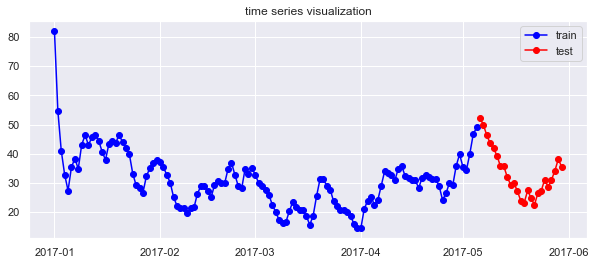

In [160]:
ID=20606
n_days=25 #for test set
data=(dataframe_generation_scores(ID=ID,inicio=10,fin=150)[0][1:][['time_vector_days','smooth_average_score']])

#formating dates (taking as default begining 01/01/2017 for all customers)
data.index=pd.date_range(start='1/1/2017', periods=len(data.time_vector_days))
data['value']=data.smooth_average_score
data=data.drop(columns=['time_vector_days','smooth_average_score'])

plt.figure(figsize=(10,4))
plt.plot(data[:-n_days],color='blue',marker='o',label='train')
plt.plot(data[-n_days:], color='red',marker='o',label='test')
plt.legend()
plt.title('time series visualization')
plt.savefig('plot_tesis2.jpg')

In [22]:
print(len(data[:-n_days]),len(data[-n_days:]))

125 25


#### Winter's method

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [159]:
data_wm=data.copy()

n_train=len(data_wm)-n_days
train=data_wm[0:n_train]
#train=train.loc['2017-03-15':] 
test=data_wm[n_train:]

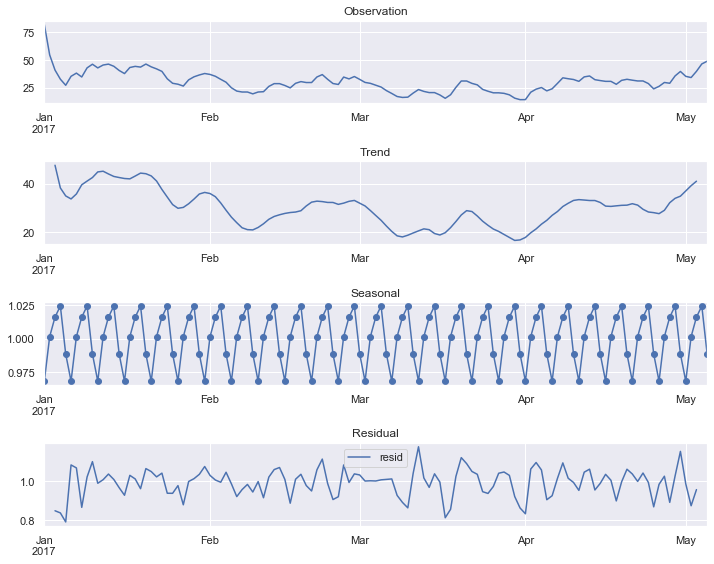

In [25]:
result = seasonal_decompose(train, model='multiplicative',freq=5)
#result.plot()
#plt.show()

fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(10,8))
result.observed.plot(ax=ax0,title='Observation')
result.trend.plot(ax=ax1,title='Trend')
result.seasonal.plot(ax=ax2,marker='o',title='Seasonal')
result.resid.plot(ax=ax3, title='Residual')
plt.legend()
plt.tight_layout()
plt.savefig('plot_tesis3.jpg')

In [26]:
model_ES = ExponentialSmoothing(train, trend='mul',seasonal='mul', seasonal_periods=5).fit()  #seasonal periods an be 7
pred_HW = model_ES.predict(start=test.index[0], end=test.index[-1])
pred_HW=pred_HW.to_frame().rename(columns={0:'Predictions_HW'})
pred_HW=pred_HW.iloc[:,0]

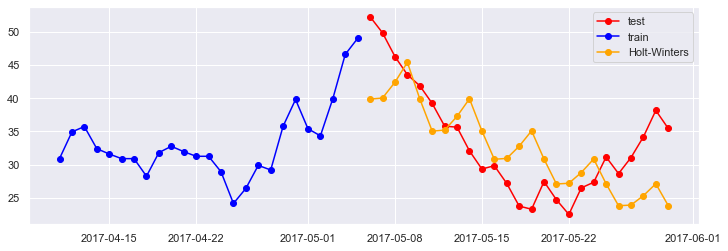

In [27]:
## ploting results
plt.figure(figsize=(12,4))
plt.plot(test,label='test',marker='o',color='red')
plt.plot(train[100:],label='train', marker='o',color='blue')
plt.plot(pred_HW.index, pred_HW, label='Holt-Winters',marker='o',color='orange')
plt.legend(loc='best')
plt.savefig('plot_tesis4.jpg')

In [28]:
##rolling prediction for holt-winters
def rolling_HW(seasonal_periods=7): #the arguments are the hyper parameters
    history= [x for x in train.value]
    predictions = list()
    for t in range(len(test)):
        model_ES=ExponentialSmoothing(history, trend='mul',seasonal='mul', seasonal_periods=seasonal_periods).fit()
        pred_HW = model_ES.predict()
        yhat = pred_HW[0]
        predictions.append(yhat)
        obs = test.values[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_absolute_error(test, predictions)
    rolling_predictions=predictions
    rolling_predictions_HW=pd.DataFrame(data=rolling_predictions,index=test.index,columns=['rolling_predictions_HW']) # converting to dataframe
    rolling_predictions_HW=rolling_predictions_HW.iloc[:,0] #converting to pandas series
    return  rolling_predictions_HW, error

In [29]:
rolling_predictions_HW=rolling_HW()[0]

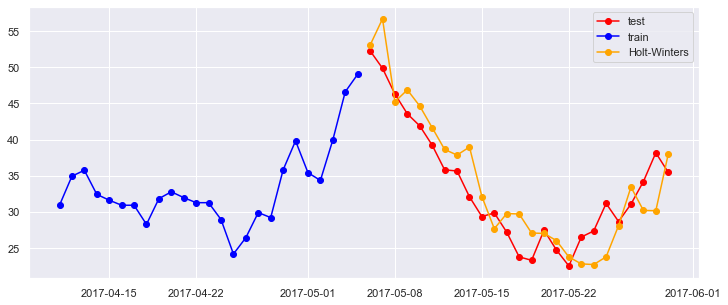

In [30]:
plt.figure(figsize=(12,5))
plt.plot(test,label='test',marker='o',color='red')
plt.plot(train[100:],label='train', marker='o',color='blue')
plt.plot(rolling_predictions_HW, label='Holt-Winters',marker='o',color='orange')
plt.legend(loc='best')
plt.savefig('plot_tesis5.jpg')

##### cross validation of the hyperparameter # seasonal days

In [31]:
### cross validation of the hyperparameter # seasonal days
list_seasonal_days=[3,5,7,9,12,15,18,20,22,25]
MAE_list=[]
for i in list_seasonal_days:
    mae_hw=rolling_HW(seasonal_periods=i)[1]
    MAE_list.append(mae_hw)

In [32]:
pd.DataFrame(data=MAE_list,index=list_seasonal_days,columns=['MAE'])

,MAE
3,3.109643
5,3.778226
7,3.301486
9,5.167547
12,3.382919
15,5.096331
18,4.005586
20,13.956648
22,4.714932
25,4.660437


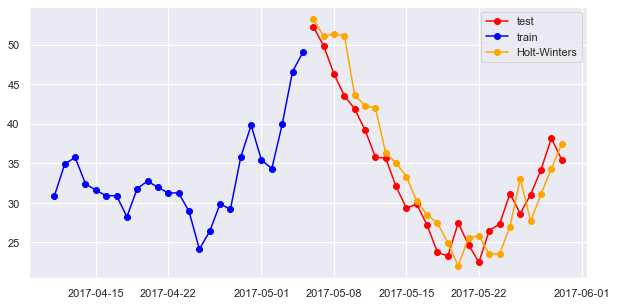

In [34]:
## using the new seasonal periods
rolling_predictions_HW_tunned=rolling_HW(seasonal_periods=3)[0]
plt.figure(figsize=(10,5))
plt.plot(test,label='test',marker='o',color='red')
plt.plot(train[100:],label='train', marker='o',color='blue')
plt.plot(rolling_predictions_HW_tunned, label='Holt-Winters',marker='o',color='orange')
plt.legend(loc='best')
plt.savefig('plot_tesis6.jpg')

#### ARMA model

In [35]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.tsa.arima_model import ARIMA,ARMAResults 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

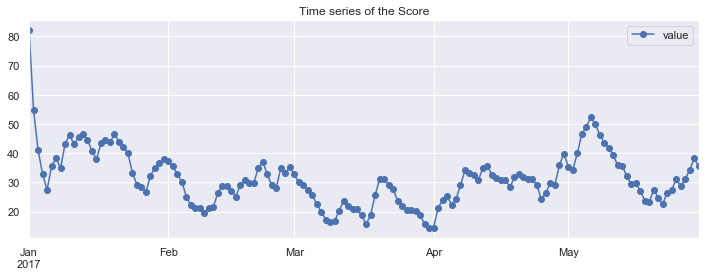

In [36]:
data.plot(figsize=(12,4),marker='o',title='Time series of the Score')

In [37]:
## splitting data, trainning and test
## specification from training
data_ts=data.copy()

n_topredict= n_days  #nnumber of days that will be removed 

n_train=len(data_ts)-n_topredict
train=data_ts[0:n_train]
#train=train.loc['2017-03-10':]  #in case of cut of the training data
test=data_ts[n_train:]

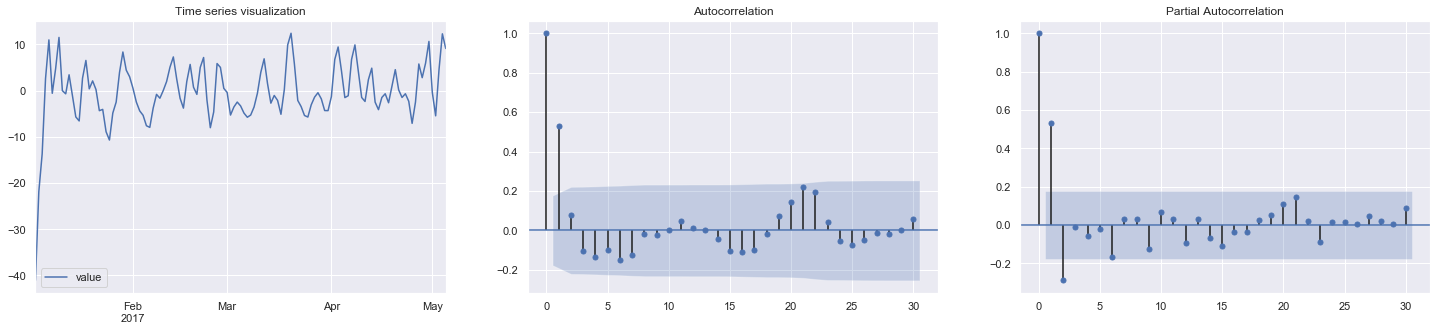

<Figure size 432x288 with 0 Axes>

In [56]:
sample=train.diff(periods=2)[2:]

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,5))
sample.plot(ax=axes[0],title='Time series visualization')
plot_acf(sample,lags=30,ax=axes[1])
plot_pacf(sample,lags=30,ax=axes[2]) # arima (p4,q4) 
plt.show()
plt.savefig('plot_tesis7.jpg')

In [57]:
if adfuller(sample)[1]>0.05:
    print('pvalue:'+str(adfuller(sample)[1])+' data is non stationary')# pvalue
else:
    print('pvalue:'+str(adfuller(sample)[1])+'data is weakly stationary')

pvalue:0.008925748294171008data is weakly stationary


In [62]:
# model looks good for the three first predictions
my_order = (0,2,1)
#my_seasonal_order = (0, 0, 0, 0)
#model_arma=SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)
model_arma=ARIMA(train, order=my_order)
model_arma_fit=model_arma.fit(disp=0)

print(model_arma_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  123
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -343.822
Method:                       css-mle   S.D. of innovations              3.958
Date:                Tue, 16 Jun 2020   AIC                            693.644
Time:                        16:01:33   BIC                            702.080
Sample:                    01-03-2017   HQIC                           697.071
                         - 05-05-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2065      0.235      0.879      0.380      -0.254       0.667
ma.L1.D2.value    -0.3461      0.122     -2.847      0.004      -0.584      -0.108
                                    

In [49]:
#initial prediction 
pred_start_date = test.index[0]
pred_end_date = test.index[-1]

predictions=model_arma_fit.forecast(len(test))
predictions_arima=pd.DataFrame(data=predictions[0],index=test.index,columns=['Predictions_Arima'])
predictions_arima=predictions_arima.iloc[:,0]

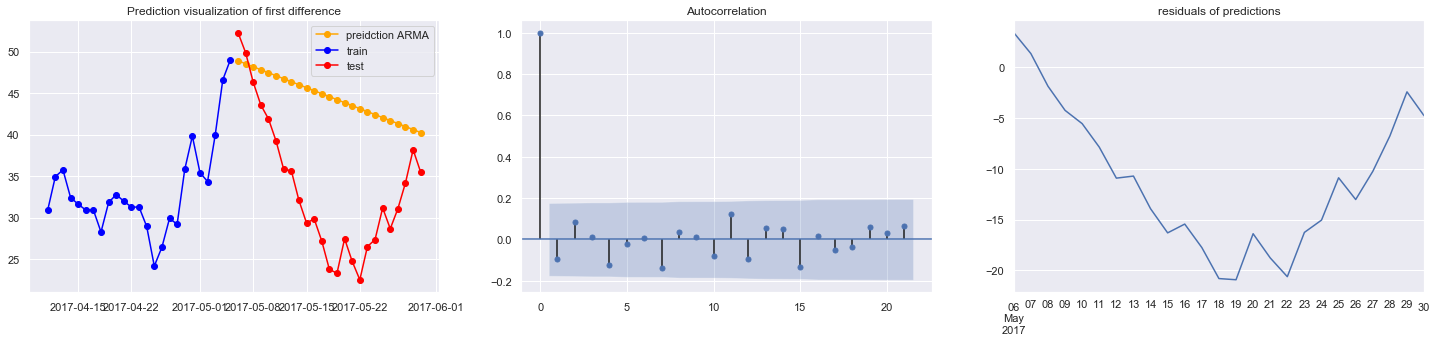

<Figure size 432x288 with 0 Axes>

In [50]:
residuals=test.iloc[:,0]-predictions_arima

#Results
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,5))
plot_acf(model_arma_fit.resid,ax=axes[1]) #auc of residuals

axes[0].plot(predictions_arima,color='orange',label='preidction ARMA',marker='o')
axes[0].plot(train[100:],color='blue',label='train',marker='o')
axes[0].plot(test,label='test',color='red',marker='o')
axes[0].title.set_text('Prediction visualization of first difference')
axes[0].legend(loc="best")

residuals.plot(ax=axes[2], title='residuals of predictions')

plt.show()
plt.savefig('plot_tesis8.jpg')

In [51]:
#acorr_ljungbox(res.resid, lags=[10], return_df=True)
ljb_test=acorr_ljungbox(model_arma_fit.resid, lags=[1,2,3,4,5,10,15,20,25,30], return_df=True)
def test_ho_jb(x):
    if x>0.05:
        return 'Do not reject H0 -> no autocorr at this lag'
    else:
        return 'Reject H0 -> autocorr at this lag'

ljb_test['result']=ljb_test.lb_pvalue.apply(test_ho_jb)
ljb_test

,lb_stat,lb_pvalue,result
1,1.126147,0.288599,Do not reject H0 -> no autocorr at this lag
2,2.055383,0.357832,Do not reject H0 -> no autocorr at this lag
3,2.074583,0.557072,Do not reject H0 -> no autocorr at this lag
4,4.008943,0.404797,Do not reject H0 -> no autocorr at this lag
5,4.078780,0.538130,Do not reject H0 -> no autocorr at this lag
10,7.704575,0.657668,Do not reject H0 -> no autocorr at this lag
15,14.517785,0.486676,Do not reject H0 -> no autocorr at this lag
20,15.736106,0.732855,Do not reject H0 -> no autocorr at this lag
25,20.071855,0.743046,Do not reject H0 -> no autocorr at this lag
30,22.594914,0.831540,Do not reject H0 -> no autocorr at this lag


In [52]:
def rolling_arma(order_arma=my_order):
    history = [x for x in train.value]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order_arma)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0][0]
        predictions.append(yhat)
        obs = test.values[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_absolute_error(test, predictions)
    aic=model_fit.aic
    rolling_predictions=predictions
    predictions_y_arima=pd.DataFrame(data=rolling_predictions,index=test.index,columns=['predictions_y_arima'])
    predictions_rolling_arima=predictions_y_arima.iloc[:,0]
    rolling_residuals=pd.DataFrame(data=np.ravel(predictions_rolling_arima.values-np.ravel(test.values)),
                                   index=test.index,columns=['Residuals'])
    return (predictions_rolling_arima,error,aic,rolling_residuals)

In [53]:
predictions_rolling_arima=rolling_arma(order_arma=my_order)[0]
rolling_residuals=rolling_arma(order_arma=my_order)[3]

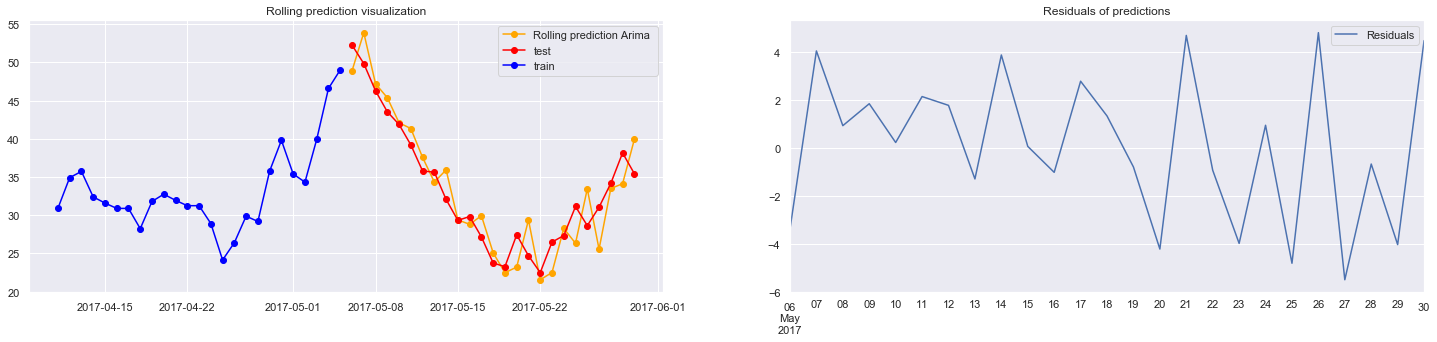

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(25,5))
axes[0].plot(predictions_rolling_arima,color='orange',marker='o',label='Rolling prediction Arima ')
axes[0].plot(test,color='red',marker='o', label='test')
axes[0].plot(train[100:],color='blue',marker='o',label='train')
axes[0].title.set_text('Rolling prediction visualization')
axes[0].legend(loc="best")

rolling_residuals.plot(ax=axes[1],title='Residuals of predictions')
plt.savefig('plot_tesis9.jpg')

##### Cross validation of the hyperparameter # different orders arima(pdq) (tuples format)

In [63]:
list_esp=[(0,1,1),(1,1,0),(1,2,1),(0,2,1)]
MAE_list=[]
AIC_list=[]
for i in list_esp:
    mae_arima=rolling_arma(order_arma=i)[1]
    aic_arima=rolling_arma(order_arma=i)[2]
    MAE_list.append(mae_arima)
    AIC_list.append(aic_arima)
data_metrics={'MAE':MAE_list,'AIC':AIC_list}
pd.DataFrame(data=data_metrics,index=list_esp)

,MAE,AIC
"(0, 1, 1)",2.581967,806.949661
"(1, 1, 0)",2.542633,808.346839
"(1, 2, 1)",2.755747,806.545111
"(0, 2, 1)",2.675779,817.758417


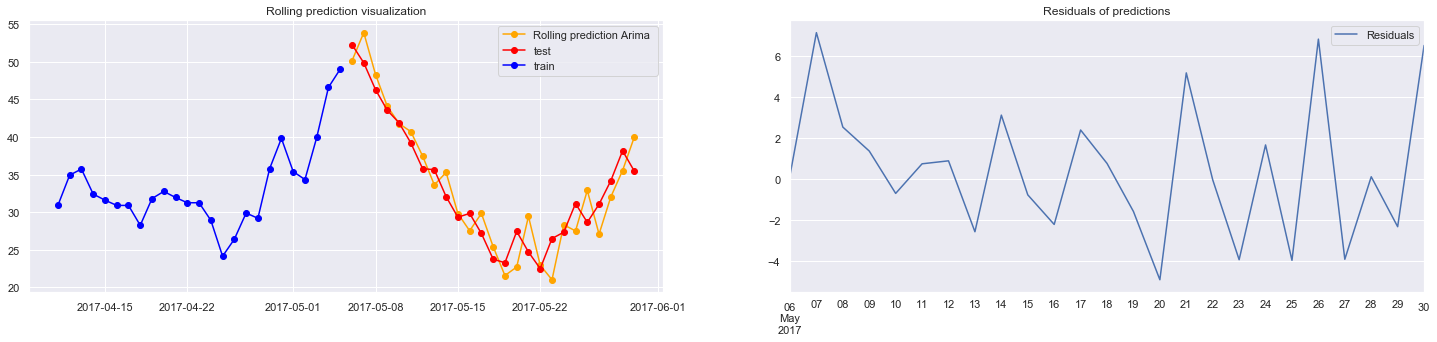

In [64]:
predictions_rolling_arima_tunned=rolling_arma(order_arma=(1,1,0))[0]
rolling_residuals=rolling_arma(order_arma=(2,2,0))[3]

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(25,5))
axes[0].plot(predictions_rolling_arima_tunned,color='orange',marker='o',label='Rolling prediction Arima ')
axes[0].plot(test,color='red',marker='o', label='test')
axes[0].plot(train[100:],color='blue',marker='o',label='train')
axes[0].title.set_text('Rolling prediction visualization')
axes[0].legend(loc="best")

rolling_residuals.plot(ax=axes[1],title='Residuals of predictions')
plt.savefig('plot_tesis10.jpg')

### Support vector machine

In [65]:
from sklearn.svm import SVR
import statsmodels.api as sm
from sklearn.base import clone

In [161]:
data_svm=data.copy()
#data_svm['day_month_vector']=data_svm.index.day
data_svm['time_vector']=range(1,len(data_svm)+1)

data_svm.head()

,value,time_vector
2017-01-01,82.119562,1
2017-01-02,54.746374,2
2017-01-03,41.059781,3
2017-01-04,32.847825,4
2017-01-05,27.373187,5


In [162]:
n_topredict=n_days
n_train=len(data_svm)-n_topredict
train=data_svm[0:n_train]
test=data_svm[n_train:]

X_train=train.iloc[:,1:].values
Y_train=np.array(train.value).reshape(-1, 1)
Y_train=np.ravel(Y_train)

X_test=test.iloc[:,1:].values
Y_test=np.array(test.value).reshape(-1, 1)
Y_test=np.ravel(Y_test)

In [163]:
## time and value are given as arrays
svr_rfb=SVR(kernel='rbf',C=50,gamma=0.1,epsilon=0.8)  #linear kernel overfits
svr_rfb.fit(X_train,Y_train)

SVR(C=50, cache_size=200, coef0=0.0, degree=3, epsilon=0.8, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [164]:
svr_prediction=pd.DataFrame(data=svr_rfb.predict(X_test),index=test.index,columns=['SVR-prediction'])

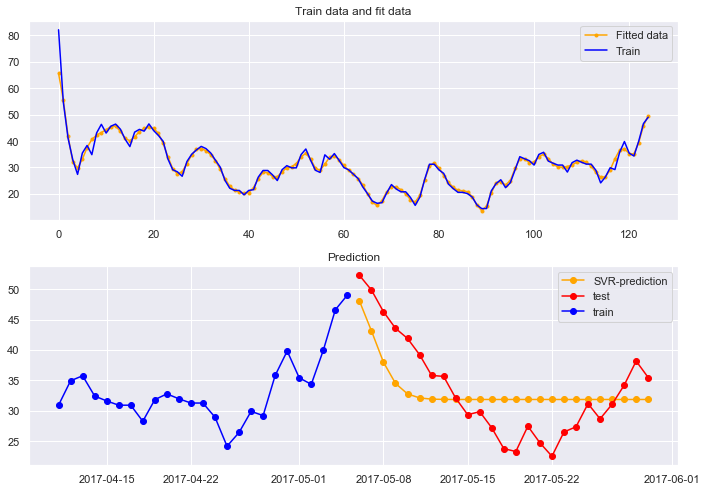

<Figure size 432x288 with 0 Axes>

In [165]:
## fitting the model into the train data
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,7))

axes[0].plot(svr_rfb.predict(X_train),marker='.',color='orange',label='Fitted data')
axes[0].plot(Y_train,color='blue',label='Train')
axes[0].legend()
axes[0].title.set_text('Train data and fit data')

axes[1].plot(svr_prediction,color='orange',marker='o',label='SVR-prediction')
axes[1].plot(test['value'],color='red',marker='o',label='test')
axes[1].plot(train['value'][100:],color='blue',marker='o',label='train')
axes[1].legend()
axes[1].title.set_text('Prediction')

plt.tight_layout()
plt.show()
plt.savefig('plot_tesis11.jpg')

In [158]:
##rolling prediction
def rolling_prediction_SVR(C=5,gamma=0.1,epsilon=0.1):
    X_history= [x for x in list(np.ravel(X_train))]
    Y_history= [x for x in list(Y_train)]
    predictions = list()
    
    for t in range(len(Y_test)):
        #reshaping in numpy array
        X_history=np.array(X_history).reshape(-1,1)
        Y_history=np.array(Y_history)

        model_svr_rfb=SVR(kernel='rbf',C=C,gamma=gamma,epsilon=epsilon) #linear kernel overfits
        model_svr_rfb.fit(X_history,Y_history)
        pred_svr=model_svr_rfb.predict(np.array([[X_test[t][0]]]))
        yhat = pred_svr[0]
        predictions.append(yhat)

        #converting to list arrays
        X_history= [x for x in list(np.ravel(X_history))]
        Y_history= [x for x in list(Y_history)]

        obs_x = list(np.ravel(X_test))[t]
        obs_y = list(Y_test)[t]
        X_history.append(obs_x)
        Y_history.append(obs_y)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_absolute_error(list(Y_test), predictions)
    rolling_predictions=predictions
    rolling_predictions_SVR=pd.DataFrame(data=rolling_predictions,index=test.index,columns=['rolling_predictions_SVR']) # converting to dataframe
    rolling_predictions_SVR=rolling_predictions_SVR.iloc[:,0] #converting to pandas series
    return  rolling_predictions_SVR, error

In [72]:
rolling_predictions_SVR=rolling_prediction_SVR(C=5,gamma=0.1,epsilon=0.1)[0]

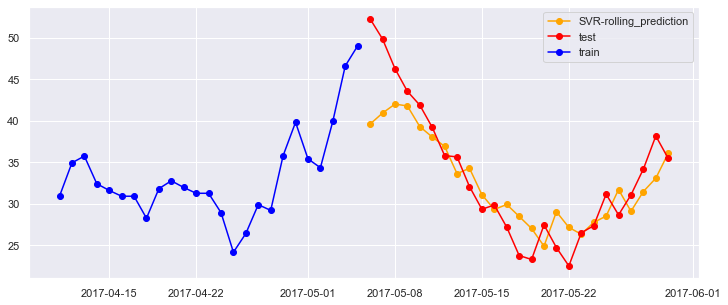

In [73]:
## fitting the model into the train data
plt.figure(figsize=(12,5))
plt.plot(rolling_predictions_SVR,color='orange',marker='o',label='SVR-rolling_prediction')
plt.plot(test['value'],color='red',marker='o',label='test')
plt.plot(train['value'][100:],color='blue',marker='o',label='train')
plt.legend()
plt.savefig('plot_tesis12.jpg')
plt.show()


##### Cross validation

In [74]:
C_list=[1,5,10,15,20,25,30,40,50,100]
epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

error_df_cv_svr=pd.DataFrame(index=C_list,columns=epsilon_list)
for i in C_list:
    for j in epsilon_list:
        mae=rolling_prediction_SVR(C=i,gamma=0.1,epsilon=j)[1]
        error_df_cv_svr.loc[i,j]=round(mae,2)
error_df_cv_svr

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
1,5.38,5.4,5.4,5.41,5.42,5.42,5.43,5.43,5.44
5,3.14,3.12,3.11,3.1,3.1,3.09,3.11,3.12,3.12
10,2.63,2.64,2.61,2.59,2.57,2.58,2.57,2.58,2.6
15,2.51,2.46,2.46,2.45,2.46,2.47,2.45,2.45,2.44
20,2.54,2.53,2.55,2.52,2.5,2.49,2.45,2.42,2.42
25,2.65,2.63,2.63,2.58,2.54,2.48,2.43,2.4,2.42
30,2.66,2.66,2.67,2.62,2.54,2.47,2.44,2.42,2.44
40,2.76,2.69,2.66,2.61,2.55,2.47,2.43,2.39,2.41
50,2.79,2.73,2.7,2.65,2.57,2.46,2.4,2.34,2.37
100,2.9,2.86,2.78,2.73,2.65,2.58,2.51,2.46,2.39


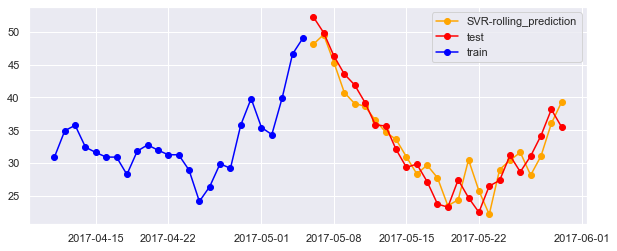

In [75]:
rolling_predictions_SVR_tunned=rolling_prediction_SVR(C=50,gamma=0.1,epsilon=0.8)[0]
## fitting the model into the train data
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions_SVR_tunned,color='orange',marker='o',label='SVR-rolling_prediction')
plt.plot(test['value'],color='red',marker='o',label='test')
plt.plot(train['value'][100:],color='blue',marker='o',label='train')
plt.legend()

plt.savefig('plot_tesis13.jpg')
plt.show()

### Recurrent  Neural Network

In [76]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
tf.__version__

'2.0.0-alpha0'

In [77]:
data_rnn=data.copy()
n_days_test=n_days
Train=data_rnn[:-n_days_test]
Test=data_rnn[-n_days_test:]

In [78]:
# fit scaler
scaler = MinMaxScaler()
scaler = scaler.fit(Train)

Train_scaled=scaler.transform(Train)
Test_scaled=scaler.transform(Test)

In [79]:
n_inputs= 20
n_features= 1

generator=TimeseriesGenerator(Train_scaled,Train_scaled,length=n_inputs,batch_size=1)

model = keras.Sequential()
model.add(keras.layers.LSTM(units=150,activation='relu',input_shape=(n_inputs,n_features)))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_absolute_error',optimizer='adam')

In [80]:
hist_model=model.fit_generator(generator,epochs=30,verbose=0)

In [81]:
#model.save("model_good_ID_17891.h5")

In [82]:
#preparing data for training the X training
X_train_block=[]
for i in range(len(Train)-n_inputs):
    block=list(Train_scaled.reshape((-1)))[i:i+n_inputs]
    X_train_block.append(block)
X_train_block=np.array(X_train_block)
X_train_block=X_train_block.reshape((X_train_block.shape[0],X_train_block.shape[1],1))

pred=scaler.inverse_transform(model.predict(X_train_block))
fitted=pd.DataFrame(data=pred,index=Train[n_inputs:].index,columns=['fitted'])

In [83]:
#preidction of the test
pred_list=[]
batch=Train_scaled[-n_inputs:].reshape((1,n_inputs,n_features))
for i in range(n_days_test):
    pred_list.append(model.predict(batch)[0])
    batch=np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
predictions_LSTM=pd.DataFrame(scaler.inverse_transform(pred_list),index=Test.index,columns=['Predictions'])
predictions_LSTM=predictions_LSTM.iloc[:,0]

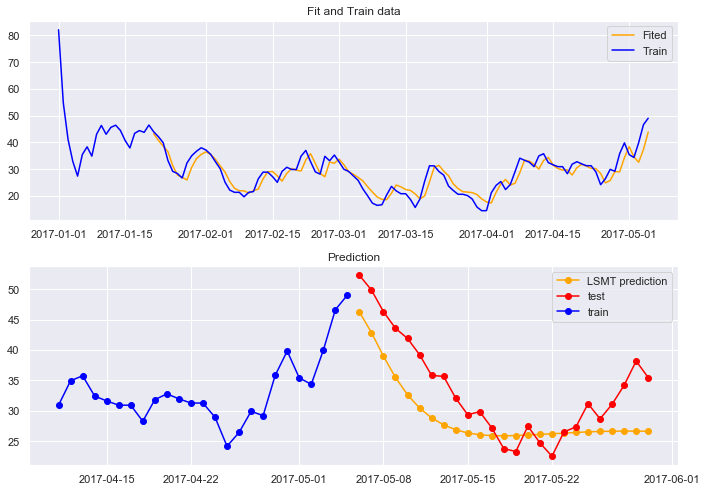

In [84]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,7))

axes[0].plot(fitted,color='orange',label='Fited')
axes[0].plot(Train,color='blue',label='Train')
axes[0].legend()
axes[0].title.set_text('Fit and Train data')

axes[1].plot(predictions_LSTM,label='LSMT prediction',color='orange',marker='o')
axes[1].plot(Test,label='test',color='red',marker='o')
axes[1].plot(Train[100:],label='train',color='blue',marker='o')
axes[1].legend()
axes[1].title.set_text('Prediction')

plt.tight_layout()
plt.savefig('plot_tesis14.jpg')
plt.show()

In [85]:
#expanding window prediction
predictions=[]
history_list=list(Train_scaled)
input_to_predict=np.array(history_list[-n_inputs:]).reshape((1,n_inputs,1))

for i in range(len(Test)):
    pred=model.predict(input_to_predict)
    pred=float(scaler.inverse_transform(pred))
    predictions.append(pred)
    obs=list(np.ravel(Test_scaled))[i]
    history_list.append(obs)
    input_to_predict=np.array(history_list[-n_inputs:]).reshape((1,n_inputs,1))
rolling_predictions_LSTM=np.array(predictions).reshape(len(predictions),1)
rolling_predictions_LSTM=pd.DataFrame(rolling_predictions_LSTM,index=Test.index,columns=['predictions_LSTM'])

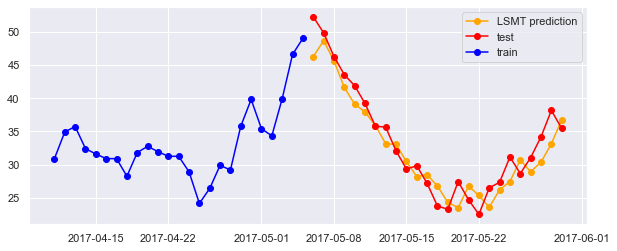

In [86]:
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions_LSTM,label='LSMT prediction',color='orange',marker='o')
plt.plot(Test,label='test',color='red',marker='o')
plt.plot(Train[100:],label='train',color='blue',marker='o')

plt.savefig('plot_tesis15.jpg')
plt.legend()


### Summary

In [87]:
l1=(Test.value.to_frame())
l2=rolling_predictions_HW_tunned
l3=predictions_rolling_arima_tunned
l4=rolling_predictions_SVR_tunned
l5=rolling_predictions_LSTM

summ_predictions=pd.concat([l1,l2,l3,l4,l5], axis=1, sort=False)
summ_predictions.head()

,value,rolling_predictions_HW,predictions_y_arima,rolling_predictions_SVR,predictions_LSTM
2017-05-06,52.277538,53.252568,50.128799,48.066433,46.258244
2017-05-07,49.857679,51.063323,53.867199,49.556109,48.661316
2017-05-08,46.287027,51.328137,48.300011,45.295781,45.637386
2017-05-09,43.549708,51.148019,44.076487,40.735393,41.623718
2017-05-10,41.883042,43.631985,41.787936,39.049334,39.107033


In [88]:
list_metric=['MAE_HW','MAE_arima','MAE_SVR','MAE_LSMT']
list_error=[mean_absolute_error(summ_predictions.value, summ_predictions.rolling_predictions_HW),
           mean_absolute_error(summ_predictions.value, summ_predictions.predictions_y_arima),
            mean_absolute_error(summ_predictions.value, summ_predictions.rolling_predictions_SVR),
            mean_absolute_error(summ_predictions.value, summ_predictions.predictions_LSTM)]

df_errors=pd.DataFrame(data=list_error,index=list_metric)
df_errors.rename(columns={0:'value'}).transpose()

,MAE_HW,MAE_arima,MAE_SVR,MAE_LSMT
value,3.109643,2.542633,2.339773,2.25849


# other case

In [91]:
df_sample.Cus_ID.unique()

array([ 8568,  8611,  8629,  8741,  8775,  8843,  8963,  8985,  9175,
        9370,  9480,  9658,  9701,  9714,  9751,  9797,  9827,  9857,
        9881, 10174, 10204, 10224, 10289, 10542, 10563, 10683, 10741,
       11041, 11065, 11166, 11578, 11667, 11674, 11825, 12028, 12111,
       12143, 12146, 12303, 12331, 12468, 12653, 12822, 12909, 12987,
       12993, 13026, 13095, 13114, 13180, 13310, 13929, 14189, 14484,
       14500, 14507, 14508, 14567, 14599, 14610, 14844, 15070, 15078,
       15176, 15249, 15269, 15447, 15743, 15841, 16236, 16355, 16600,
       16689, 17196, 17300, 17440, 17500, 17528, 17627, 17827, 17852,
       17861, 17891, 17904, 17925, 17931, 17980, 18045, 18050, 18059,
       18071, 18083, 18110, 18117, 18123, 18127, 18128, 18137, 18146,
       18161, 18189, 18224, 18231, 18262, 18275, 18290, 18291, 18316,
       18354, 18360, 18389, 18395, 18402, 18414, 18455, 18472, 18475,
       18488, 18489, 18502, 18523, 18609, 18625, 18695, 18712, 18719,
       18735, 18746,

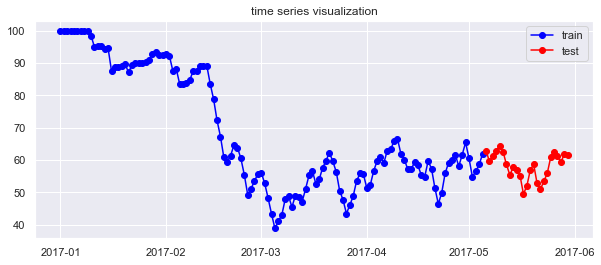

In [154]:
ID=20313
n_days=25 #for test set
data=(dataframe_generation_scores(ID=ID,inicio=10,fin=150)[0][1:][['time_vector_days','smooth_average_score']])

#formating dates (taking as default begining 01/01/2017 for all customers)
data.index=pd.date_range(start='1/1/2017', periods=len(data.time_vector_days))
data['value']=data.smooth_average_score
data=data.drop(columns=['time_vector_days','smooth_average_score'])

plt.figure(figsize=(10,4))
plt.plot(data[:-n_days],color='blue',marker='o',label='train')
plt.plot(data[-n_days:], color='red',marker='o',label='test')
plt.legend()
plt.title('time series visualization')
plt.savefig('plot_tesis2.jpg')

In [96]:
print(len(data[:-n_days]),len(data[-n_days:]))


125 25


#### Winter's method

In [97]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [98]:
data_wm=data.copy()

n_train=len(data_wm)-n_days
train=data_wm[0:n_train]
#train=train.loc['2017-03-15':] 
test=data_wm[n_train:]

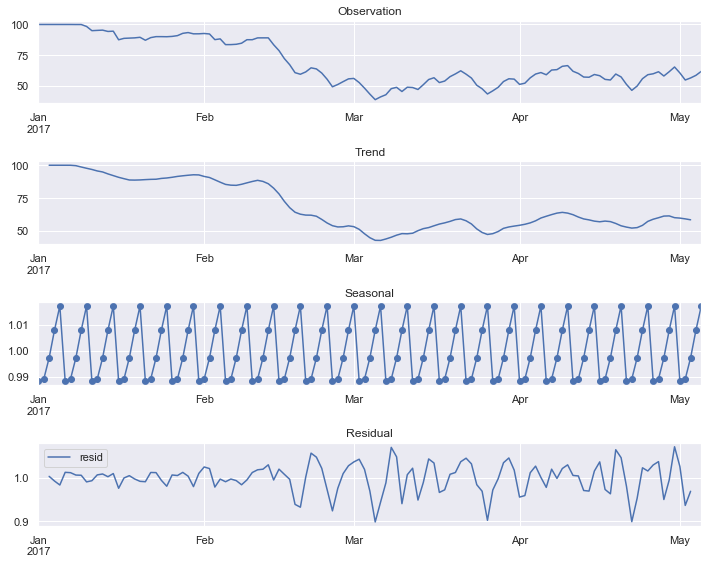

In [99]:
result = seasonal_decompose(train, model='multiplicative',freq=5)
#result.plot()
#plt.show()

fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(10,8))
result.observed.plot(ax=ax0,title='Observation')
result.trend.plot(ax=ax1,title='Trend')
result.seasonal.plot(ax=ax2,marker='o',title='Seasonal')
result.resid.plot(ax=ax3, title='Residual')
plt.legend()
plt.tight_layout()
plt.savefig('plot_tesis3.jpg')

In [100]:
model_ES = ExponentialSmoothing(train, trend='mul',seasonal='mul', seasonal_periods=5).fit()  #seasonal periods an be 7
pred_HW = model_ES.predict(start=test.index[0], end=test.index[-1])
pred_HW=pred_HW.to_frame().rename(columns={0:'Predictions_HW'})
pred_HW=pred_HW.iloc[:,0]

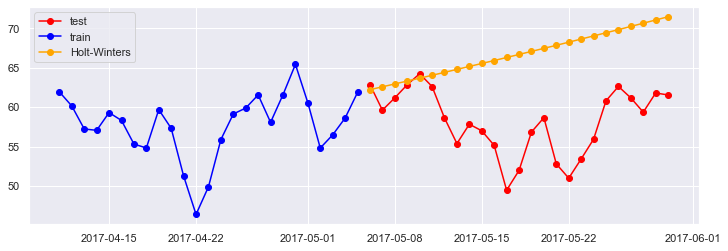

In [101]:
## ploting results
plt.figure(figsize=(12,4))
plt.plot(test,label='test',marker='o',color='red')
plt.plot(train[100:],label='train', marker='o',color='blue')
plt.plot(pred_HW.index, pred_HW, label='Holt-Winters',marker='o',color='orange')
plt.legend(loc='best')
plt.savefig('plot_tesis4.jpg')

In [102]:
##rolling prediction for holt-winters
def rolling_HW(seasonal_periods=7): #the arguments are the hyper parameters
    history= [x for x in train.value]
    predictions = list()
    for t in range(len(test)):
        model_ES=ExponentialSmoothing(history, trend='mul',seasonal='mul', seasonal_periods=seasonal_periods).fit()
        pred_HW = model_ES.predict()
        yhat = pred_HW[0]
        predictions.append(yhat)
        obs = test.values[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_absolute_error(test, predictions)
    rolling_predictions=predictions
    rolling_predictions_HW=pd.DataFrame(data=rolling_predictions,index=test.index,columns=['rolling_predictions_HW']) # converting to dataframe
    rolling_predictions_HW=rolling_predictions_HW.iloc[:,0] #converting to pandas series
    return  rolling_predictions_HW, error

In [103]:
rolling_predictions_HW=rolling_HW()[0]

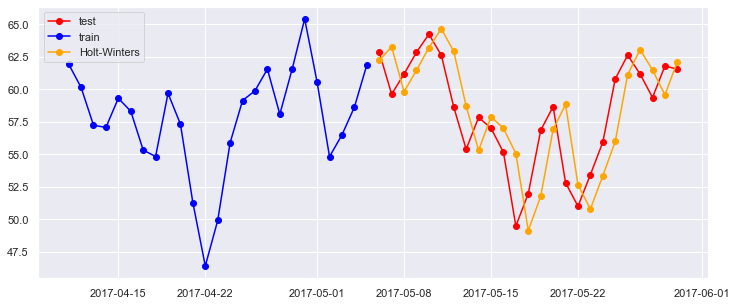

In [104]:
plt.figure(figsize=(12,5))
plt.plot(test,label='test',marker='o',color='red')
plt.plot(train[100:],label='train', marker='o',color='blue')
plt.plot(rolling_predictions_HW, label='Holt-Winters',marker='o',color='orange')
plt.legend(loc='best')
plt.savefig('plot_tesis5.jpg')

##### cross validation of the hyperparameter # seasonal days

In [106]:
### cross validation of the hyperparameter # seasonal days
list_seasonal_days=[3,5,7,9,12,15,18,20,22,25]
MAE_list=[]
for i in list_seasonal_days:
    mae_hw=rolling_HW(seasonal_periods=i)[1]
    MAE_list.append(mae_hw)

In [107]:
pd.DataFrame(data=MAE_list,index=list_seasonal_days,columns=['MAE'])

,MAE
3,2.572221
5,2.573023
7,2.572818
9,2.575189
12,2.583059
15,2.505436
18,2.742748
20,2.388726
22,3.079895
25,2.702606


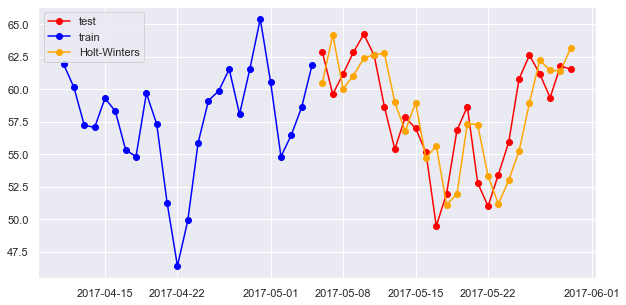

In [109]:
## using the new seasonal periods
rolling_predictions_HW_tunned=rolling_HW(seasonal_periods=15)[0]
plt.figure(figsize=(10,5))
plt.plot(test,label='test',marker='o',color='red')
plt.plot(train[100:],label='train', marker='o',color='blue')
plt.plot(rolling_predictions_HW_tunned, label='Holt-Winters',marker='o',color='orange')
plt.legend(loc='best')
plt.savefig('plot_tesis6.jpg')

#### ARMA model

In [110]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.tsa.arima_model import ARIMA,ARMAResults 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

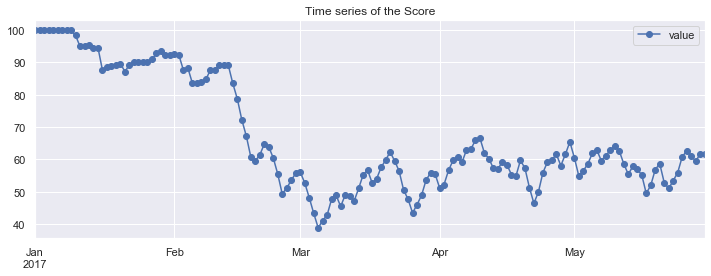

In [111]:
data.plot(figsize=(12,4),marker='o',title='Time series of the Score')

In [112]:
## splitting data, trainning and test
## specification from training
data_ts=data.copy()

n_topredict= n_days  #nnumber of days that will be removed 

n_train=len(data_ts)-n_topredict
train=data_ts[0:n_train]
#train=train.loc['2017-03-10':]  #in case of cut of the training data
test=data_ts[n_train:]

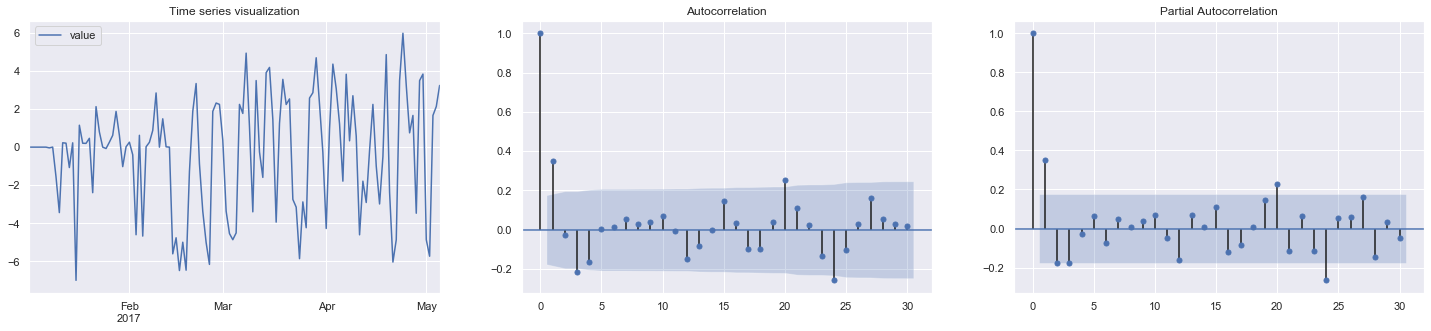

<Figure size 432x288 with 0 Axes>

In [113]:
sample=train.diff(periods=1)[1:]

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,5))
sample.plot(ax=axes[0],title='Time series visualization')
plot_acf(sample,lags=30,ax=axes[1])
plot_pacf(sample,lags=30,ax=axes[2]) # arima (p4,q4) 
plt.show()
plt.savefig('plot_tesis7.jpg')

In [114]:
if adfuller(sample)[1]>0.05:
    print('pvalue:'+str(adfuller(sample)[1])+' data is non stationary')# pvalue
else:
    print('pvalue:'+str(adfuller(sample)[1])+'data is weakly stationary')

pvalue:3.322983687385167e-10data is weakly stationary


In [126]:
# model looks good for the three first predictions
my_order = (0,1,1)
#my_seasonal_order = (0, 0, 0, 0)
#model_arma=SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)
model_arma=ARIMA(train, order=my_order)
model_arma_fit=model_arma.fit(disp=0)

print(model_arma_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  124
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -303.291
Method:                       css-mle   S.D. of innovations              2.791
Date:                Tue, 16 Jun 2020   AIC                            612.581
Time:                        16:36:02   BIC                            621.042
Sample:                    01-02-2017   HQIC                           616.018
                         - 05-05-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2979      0.341     -0.872      0.383      -0.967       0.371
ma.L1.D.value     0.3654      0.077      4.720      0.000       0.214       0.517
                                    Root

In [116]:
#initial prediction 
pred_start_date = test.index[0]
pred_end_date = test.index[-1]

predictions=model_arma_fit.forecast(len(test))
predictions_arima=pd.DataFrame(data=predictions[0],index=test.index,columns=['Predictions_Arima'])
predictions_arima=predictions_arima.iloc[:,0]

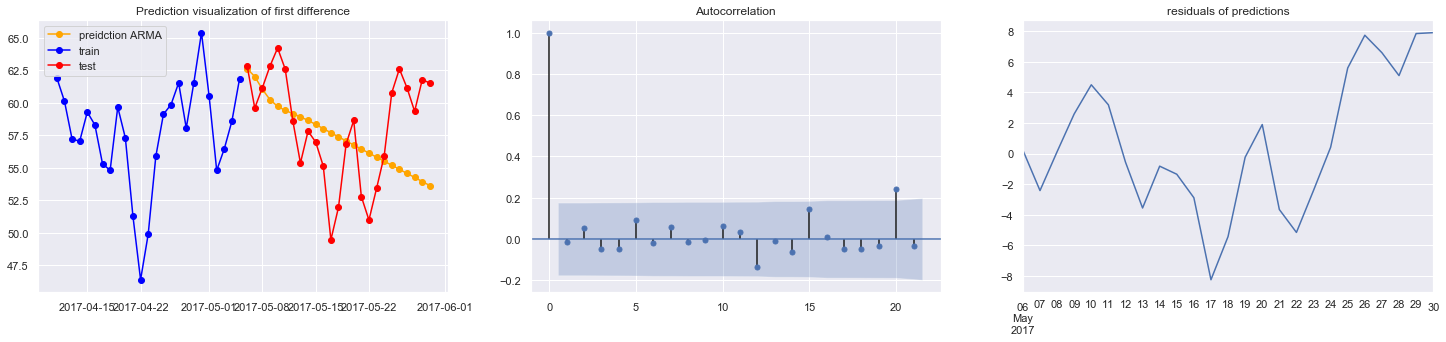

<Figure size 432x288 with 0 Axes>

In [117]:
residuals=test.iloc[:,0]-predictions_arima

#Results
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,5))
plot_acf(model_arma_fit.resid,ax=axes[1]) #auc of residuals

axes[0].plot(predictions_arima,color='orange',label='preidction ARMA',marker='o')
axes[0].plot(train[100:],color='blue',label='train',marker='o')
axes[0].plot(test,label='test',color='red',marker='o')
axes[0].title.set_text('Prediction visualization of first difference')
axes[0].legend(loc="best")

residuals.plot(ax=axes[2], title='residuals of predictions')

plt.show()
plt.savefig('plot_tesis8.jpg')

In [119]:
#acorr_ljungbox(res.resid, lags=[10], return_df=True)
ljb_test=acorr_ljungbox(model_arma_fit.resid, lags=[1,2,3,4,5,10,15,20,25,30], return_df=True)
def test_ho_jb(x):
    if x>0.05:
        return 'Do not reject H0 -> no autocorr at this lag'
    else:
        return 'Reject H0 -> autocorr at this lag'

ljb_test['result']=ljb_test.lb_pvalue.apply(test_ho_jb)
ljb_test

,lb_stat,lb_pvalue,result
1,0.027166,0.869085,Do not reject H0 -> no autocorr at this lag
2,0.410458,0.814461,Do not reject H0 -> no autocorr at this lag
3,0.695417,0.874281,Do not reject H0 -> no autocorr at this lag
4,0.978300,0.913068,Do not reject H0 -> no autocorr at this lag
5,2.135889,0.830041,Do not reject H0 -> no autocorr at this lag
10,3.191731,0.976545,Do not reject H0 -> no autocorr at this lag
15,9.428095,0.854092,Do not reject H0 -> no autocorr at this lag
20,19.085075,0.516302,Do not reject H0 -> no autocorr at this lag
25,25.876079,0.414235,Do not reject H0 -> no autocorr at this lag
30,30.270715,0.451853,Do not reject H0 -> no autocorr at this lag


In [120]:
def rolling_arma(order_arma=my_order):
    history = [x for x in train.value]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order_arma)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0][0]
        predictions.append(yhat)
        obs = test.values[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_absolute_error(test, predictions)
    aic=model_fit.aic
    rolling_predictions=predictions
    predictions_y_arima=pd.DataFrame(data=rolling_predictions,index=test.index,columns=['predictions_y_arima'])
    predictions_rolling_arima=predictions_y_arima.iloc[:,0]
    rolling_residuals=pd.DataFrame(data=np.ravel(predictions_rolling_arima.values-np.ravel(test.values)),
                                   index=test.index,columns=['Residuals'])
    return (predictions_rolling_arima,error,aic,rolling_residuals)

In [121]:
predictions_rolling_arima=rolling_arma(order_arma=my_order)[0]
rolling_residuals=rolling_arma(order_arma=my_order)[3]

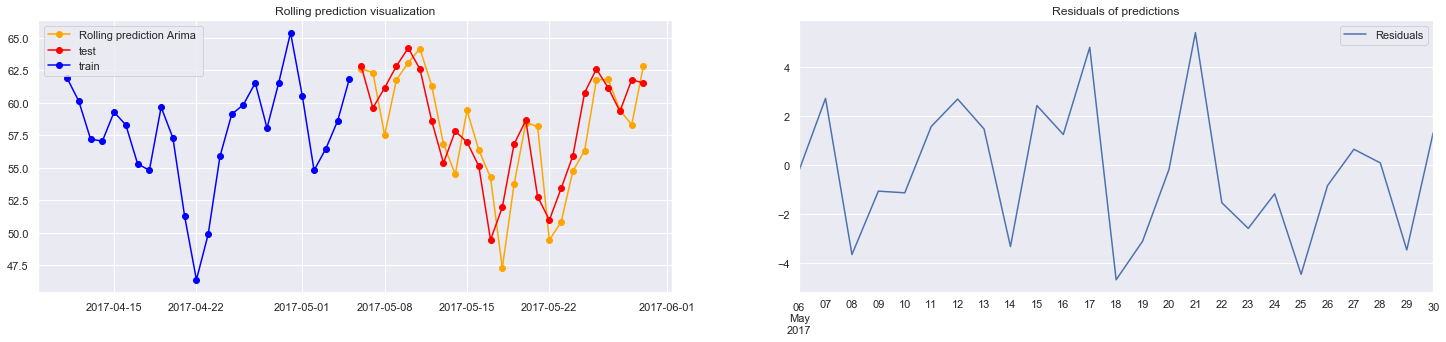

In [122]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(25,5))
axes[0].plot(predictions_rolling_arima,color='orange',marker='o',label='Rolling prediction Arima ')
axes[0].plot(test,color='red',marker='o', label='test')
axes[0].plot(train[100:],color='blue',marker='o',label='train')
axes[0].title.set_text('Rolling prediction visualization')
axes[0].legend(loc="best")

rolling_residuals.plot(ax=axes[1],title='Residuals of predictions')
plt.savefig('plot_tesis9.jpg')

##### Cross validation of the hyperparameter # different orders arima(pdq) (tuples format)

In [127]:
list_esp=[(2,1,1),(2,1,0),(1,1,0),(0,1,1)]
MAE_list=[]
AIC_list=[]
for i in list_esp:
    mae_arima=rolling_arma(order_arma=i)[1]
    aic_arima=rolling_arma(order_arma=i)[2]
    MAE_list.append(mae_arima)
    AIC_list.append(aic_arima)
data_metrics={'MAE':MAE_list,'AIC':AIC_list}
pd.DataFrame(data=data_metrics,index=list_esp)

,MAE,AIC
"(2, 1, 1)",2.230350,727.579778
"(2, 1, 0)",2.232479,727.980744
"(1, 1, 0)",2.398400,733.804367
"(0, 1, 1)",2.319530,730.220971


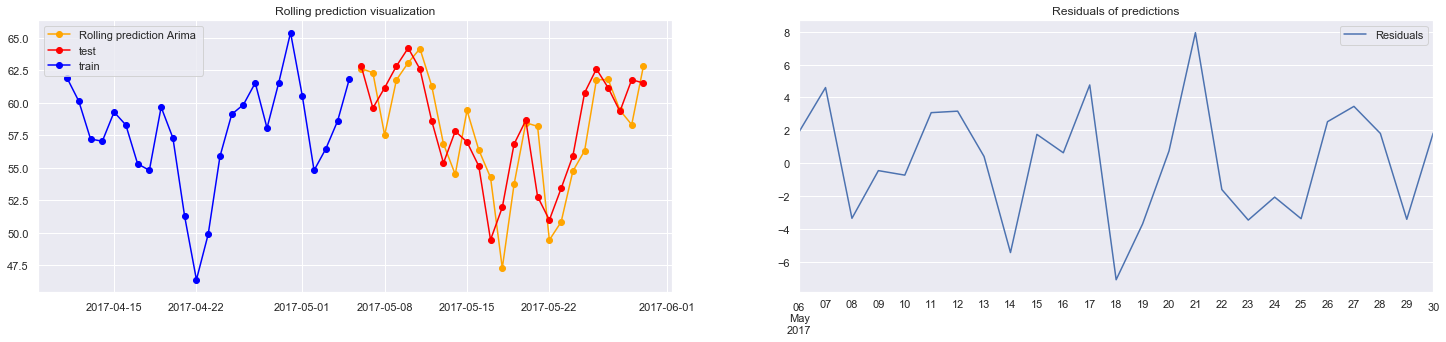

In [129]:
predictions_rolling_arima_tunned=rolling_arma(order_arma=(2,1,1))[0]
rolling_residuals=rolling_arma(order_arma=(2,2,0))[3]

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(25,5))
axes[0].plot(predictions_rolling_arima_tunned,color='orange',marker='o',label='Rolling prediction Arima ')
axes[0].plot(test,color='red',marker='o', label='test')
axes[0].plot(train[100:],color='blue',marker='o',label='train')
axes[0].title.set_text('Rolling prediction visualization')
axes[0].legend(loc="best")

rolling_residuals.plot(ax=axes[1],title='Residuals of predictions')
plt.savefig('plot_tesis10.jpg')

### Support vector machine

In [130]:
from sklearn.svm import SVR
import statsmodels.api as sm
from sklearn.base import clone

In [131]:
data_svm=data.copy()
#data_svm['day_month_vector']=data_svm.index.day
data_svm['time_vector']=range(1,len(data_svm)+1)

data_svm.head()

,value,time_vector
2017-01-01,100.0,1
2017-01-02,100.0,2
2017-01-03,100.0,3
2017-01-04,100.0,4
2017-01-05,100.0,5


In [132]:
n_topredict=n_days
n_train=len(data_svm)-n_topredict
train=data_svm[0:n_train]
test=data_svm[n_train:]

X_train=train.iloc[:,1:].values
Y_train=np.array(train.value).reshape(-1, 1)
Y_train=np.ravel(Y_train)

X_test=test.iloc[:,1:].values
Y_test=np.array(test.value).reshape(-1, 1)
Y_test=np.ravel(Y_test)

In [133]:
## time and value are given as arrays
svr_rfb=SVR(kernel='rbf',C=5,gamma=0.1,epsilon=0.1)  #linear kernel overfits
svr_rfb.fit(X_train,Y_train)

SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [134]:
svr_prediction=pd.DataFrame(data=svr_rfb.predict(X_test),index=test.index,columns=['SVR-prediction'])

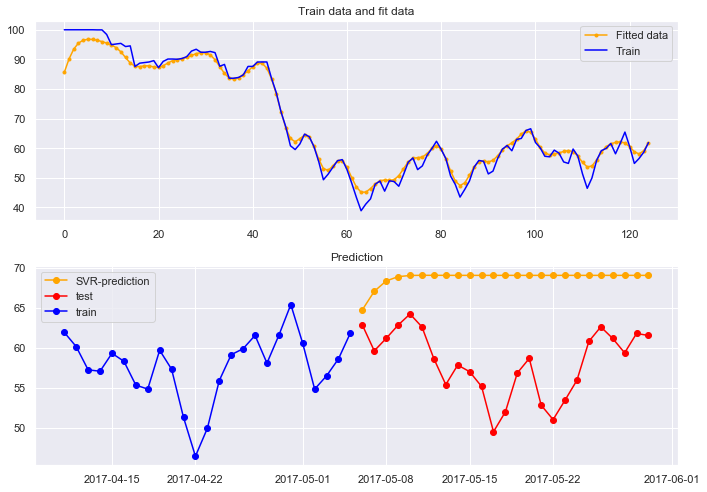

<Figure size 432x288 with 0 Axes>

In [135]:
## fitting the model into the train data
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,7))

axes[0].plot(svr_rfb.predict(X_train),marker='.',color='orange',label='Fitted data')
axes[0].plot(Y_train,color='blue',label='Train')
axes[0].legend()
axes[0].title.set_text('Train data and fit data')

axes[1].plot(svr_prediction,color='orange',marker='o',label='SVR-prediction')
axes[1].plot(test['value'],color='red',marker='o',label='test')
axes[1].plot(train['value'][100:],color='blue',marker='o',label='train')
axes[1].legend()
axes[1].title.set_text('Prediction')

plt.tight_layout()
plt.show()
plt.savefig('plot_tesis11.jpg')

In [136]:
##rolling prediction
def rolling_prediction_SVR(C=5,gamma=0.1,epsilon=0.1):
    X_history= [x for x in list(np.ravel(X_train))]
    Y_history= [x for x in list(Y_train)]
    predictions = list()
    
    for t in range(len(Y_test)):
        #reshaping in numpy array
        X_history=np.array(X_history).reshape(-1,1)
        Y_history=np.array(Y_history)

        model_svr_rfb=SVR(kernel='rbf',C=C,gamma=gamma,epsilon=epsilon) #linear kernel overfits
        model_svr_rfb.fit(X_history,Y_history)
        pred_svr=model_svr_rfb.predict(np.array([[X_test[t][0]]]))
        yhat = pred_svr[0]
        predictions.append(yhat)

        #converting to list arrays
        X_history= [x for x in list(np.ravel(X_history))]
        Y_history= [x for x in list(Y_history)]

        obs_x = list(np.ravel(X_test))[t]
        obs_y = list(Y_test)[t]
        X_history.append(obs_x)
        Y_history.append(obs_y)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_absolute_error(list(Y_test), predictions)
    rolling_predictions=predictions
    rolling_predictions_SVR=pd.DataFrame(data=rolling_predictions,index=test.index,columns=['rolling_predictions_SVR']) # converting to dataframe
    rolling_predictions_SVR=rolling_predictions_SVR.iloc[:,0] #converting to pandas series
    return  rolling_predictions_SVR, error

In [137]:
rolling_predictions_SVR=rolling_prediction_SVR(C=5,gamma=0.1,epsilon=0.1)[0]

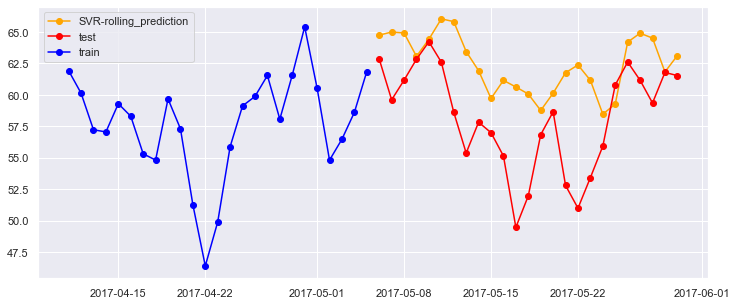

In [138]:
## fitting the model into the train data
plt.figure(figsize=(12,5))
plt.plot(rolling_predictions_SVR,color='orange',marker='o',label='SVR-rolling_prediction')
plt.plot(test['value'],color='red',marker='o',label='test')
plt.plot(train['value'][100:],color='blue',marker='o',label='train')
plt.legend()
plt.savefig('plot_tesis12.jpg')
plt.show()


##### Cross validation

In [139]:
C_list=[1,5,10,15,20,25,30,40,50,100]
epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

error_df_cv_svr=pd.DataFrame(index=C_list,columns=epsilon_list)
for i in C_list:
    for j in epsilon_list:
        mae=rolling_prediction_SVR(C=i,gamma=0.1,epsilon=j)[1]
        error_df_cv_svr.loc[i,j]=round(mae,2)
error_df_cv_svr

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
1,3.43,3.43,3.43,3.44,3.46,3.48,3.5,3.53,3.55
5,4.4,4.4,4.38,4.37,4.38,4.4,4.44,4.43,4.45
10,3.78,3.75,3.73,3.67,3.61,3.59,3.63,3.64,3.68
15,3.56,3.5,3.38,3.28,3.23,3.21,3.18,3.15,3.14
20,3.33,3.26,3.12,3.03,3,2.96,2.99,2.99,2.98
25,3.1,3.02,2.95,2.93,2.92,2.9,2.98,2.99,2.95
30,2.92,2.91,2.93,2.93,2.96,2.98,3.03,3.06,3.04
40,2.84,2.86,2.9,2.98,3.04,3.04,3.05,3.09,3.13
50,2.83,2.91,2.94,2.96,2.97,2.99,2.99,2.99,2.99
100,2.93,3,3,3,2.96,2.91,2.86,2.82,2.83


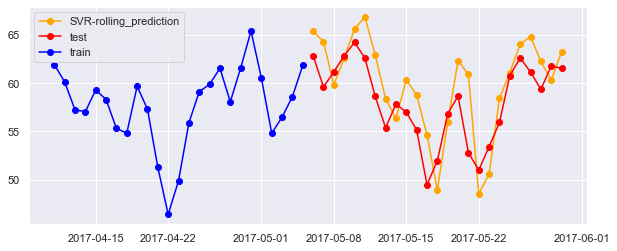

In [140]:
rolling_predictions_SVR_tunned=rolling_prediction_SVR(C=100,gamma=0.1,epsilon=0.8)[0]
## fitting the model into the train data
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions_SVR_tunned,color='orange',marker='o',label='SVR-rolling_prediction')
plt.plot(test['value'],color='red',marker='o',label='test')
plt.plot(train['value'][100:],color='blue',marker='o',label='train')
plt.legend()

plt.savefig('plot_tesis13.jpg')
plt.show()

### Recurrent  Neural Network

In [141]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
tf.__version__

'2.0.0-alpha0'

In [142]:
data_rnn=data.copy()
n_days_test=n_days
Train=data_rnn[:-n_days_test]
Test=data_rnn[-n_days_test:]

In [143]:
# fit scaler
scaler = MinMaxScaler()
scaler = scaler.fit(Train)

Train_scaled=scaler.transform(Train)
Test_scaled=scaler.transform(Test)

In [144]:
n_inputs= 20
n_features= 1

generator=TimeseriesGenerator(Train_scaled,Train_scaled,length=n_inputs,batch_size=1)

model = keras.Sequential()
model.add(keras.layers.LSTM(units=150,activation='relu',input_shape=(n_inputs,n_features)))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_absolute_error',optimizer='adam')

In [145]:
hist_model=model.fit_generator(generator,epochs=30,verbose=0)

In [146]:
#model.save("model_good_ID_17891.h5")

In [147]:
#preparing data for training the X training
X_train_block=[]
for i in range(len(Train)-n_inputs):
    block=list(Train_scaled.reshape((-1)))[i:i+n_inputs]
    X_train_block.append(block)
X_train_block=np.array(X_train_block)
X_train_block=X_train_block.reshape((X_train_block.shape[0],X_train_block.shape[1],1))

pred=scaler.inverse_transform(model.predict(X_train_block))
fitted=pd.DataFrame(data=pred,index=Train[n_inputs:].index,columns=['fitted'])

In [148]:
#preidction of the test
pred_list=[]
batch=Train_scaled[-n_inputs:].reshape((1,n_inputs,n_features))
for i in range(n_days_test):
    pred_list.append(model.predict(batch)[0])
    batch=np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
predictions_LSTM=pd.DataFrame(scaler.inverse_transform(pred_list),index=Test.index,columns=['Predictions'])
predictions_LSTM=predictions_LSTM.iloc[:,0]

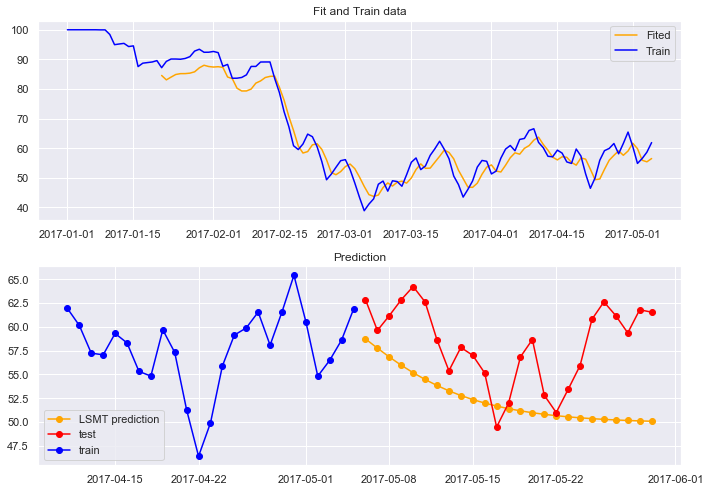

In [149]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,7))

axes[0].plot(fitted,color='orange',label='Fited')
axes[0].plot(Train,color='blue',label='Train')
axes[0].legend()
axes[0].title.set_text('Fit and Train data')

axes[1].plot(predictions_LSTM,label='LSMT prediction',color='orange',marker='o')
axes[1].plot(Test,label='test',color='red',marker='o')
axes[1].plot(Train[100:],label='train',color='blue',marker='o')
axes[1].legend()
axes[1].title.set_text('Prediction')

plt.tight_layout()
plt.savefig('plot_tesis14.jpg')
plt.show()

In [150]:
#expanding window prediction
predictions=[]
history_list=list(Train_scaled)
input_to_predict=np.array(history_list[-n_inputs:]).reshape((1,n_inputs,1))

for i in range(len(Test)):
    pred=model.predict(input_to_predict)
    pred=float(scaler.inverse_transform(pred))
    predictions.append(pred)
    obs=list(np.ravel(Test_scaled))[i]
    history_list.append(obs)
    input_to_predict=np.array(history_list[-n_inputs:]).reshape((1,n_inputs,1))
rolling_predictions_LSTM=np.array(predictions).reshape(len(predictions),1)
rolling_predictions_LSTM=pd.DataFrame(rolling_predictions_LSTM,index=Test.index,columns=['predictions_LSTM'])

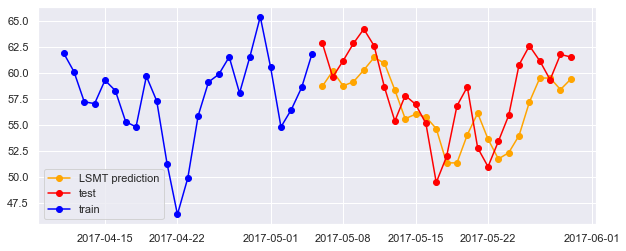

In [151]:
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions_LSTM,label='LSMT prediction',color='orange',marker='o')
plt.plot(Test,label='test',color='red',marker='o')
plt.plot(Train[100:],label='train',color='blue',marker='o')

plt.savefig('plot_tesis15.jpg')
plt.legend()


### Summary

In [152]:
l1=(Test.value.to_frame())
l2=rolling_predictions_HW_tunned
l3=predictions_rolling_arima_tunned
l4=rolling_predictions_SVR_tunned
l5=rolling_predictions_LSTM

summ_predictions=pd.concat([l1,l2,l3,l4,l5], axis=1, sort=False)
summ_predictions.head()

,value,rolling_predictions_HW,predictions_y_arima,rolling_predictions_SVR,predictions_LSTM
2017-05-06,62.854685,60.487256,62.641045,65.400732,58.728184
2017-05-07,59.611442,64.194644,62.331509,64.281642,60.179058
2017-05-08,61.171315,60.044472,57.522918,59.835245,58.764893
2017-05-09,62.837590,61.036381,61.773952,62.607478,59.150414
2017-05-10,64.228336,62.376061,63.096592,65.604307,60.282234


In [153]:
list_metric=['MAE_HW','MAE_arima','MAE_SVR','MAE_LSMT']
list_error=[mean_absolute_error(summ_predictions.value, summ_predictions.rolling_predictions_HW),
           mean_absolute_error(summ_predictions.value, summ_predictions.predictions_y_arima),
            mean_absolute_error(summ_predictions.value, summ_predictions.rolling_predictions_SVR),
            mean_absolute_error(summ_predictions.value, summ_predictions.predictions_LSTM)]

df_errors=pd.DataFrame(data=list_error,index=list_metric)
df_errors.rename(columns={0:'value'}).transpose()

,MAE_HW,MAE_arima,MAE_SVR,MAE_LSMT
value,2.505436,2.23035,2.816166,2.865417
